In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('./data/data.csv')


In [3]:
df.head()

,Unnamed: 0,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle,department,product_id,add_to_cart_order,reordered,aisle_id,department_id
0,0,2539329,1,prior,1,2,8,NaN,Soda,soft drinks,beverages,196,1,0,77,7
1,1,2539329,1,prior,1,2,8,NaN,Organic Unsweetened Vanilla Almond Milk,soy lactosefree,dairy eggs,14084,2,0,91,16
2,2,2539329,1,prior,1,2,8,NaN,Original Beef Jerky,popcorn jerky,snacks,12427,3,0,23,19
3,3,2539329,1,prior,1,2,8,NaN,Aged White Cheddar Popcorn,popcorn jerky,snacks,26088,4,0,23,19
4,4,2539329,1,prior,1,2,8,NaN,XL Pick-A-Size Paper Towel Rolls,paper goods,household,26405,5,0,54,17


### R(Recency) 구하기

, 고객의 **Recency**를 구하려면:

1. **고객별로 가장 최근 주문을 찾고** (`order_number` 최대값).
2. 해당 주문의 `days_since_prior_order` 값을 **Recency**로 사용하면 수 있습니다.

In [54]:
# 가장 최근에 주문한 내역 
max_order_numbers = df.groupby('user_id')['order_number'].max().reset_index()

In [56]:
max_order_numbers.columns = ['user_id', 'max_order_number']

In [60]:
max_order_numbers

,user_id,max_order_number
0,1,10
1,2,14
2,3,12
3,4,5
4,5,4
...,...,...
206204,206205,3
206205,206206,67
206206,206207,16
206207,206208,49


In [62]:
df_search_r = pd.merge(df, max_order_numbers, on='user_id', how='left')

In [72]:
RFR = df_search_r[df_search_r['order_number'] == df_search_r['max_order_number']].groupby('user_id')['days_since_prior_order'].min().reset_index()

In [76]:
RFR.columns = ['user_id', 'recency']

### F(Frequency) 구하기

In [91]:
user_order_frequency = df.groupby('user_id')['order_id'].nunique().reset_index()

In [97]:
RFR = pd.merge(RFR, user_order_frequency, on='user_id', how='inner')

In [99]:
RFR.columns

Index(['user_id', 'recency', 'order_id'], dtype='object')

In [105]:
RFR.rename(columns = {'order_id':'frequency'}, inplace=True)

In [107]:
RFR

,user_id,recency,frequency
0,1,30.0,10
1,2,13.0,14
2,3,15.0,12
3,4,0.0,5
4,5,19.0,4
...,...,...,...
206204,206205,10.0,3
206205,206206,11.0,67
206206,206207,18.0,16
206207,206208,7.0,49


### R(Reordered) 구하기

In [112]:
user_reordered_frequency = df.groupby('user_id')['reordered'].sum().reset_index()

In [130]:
RFR = pd.merge(RFR, user_reordered_frequency, on='user_id', how='inner')

In [132]:
RFR

,user_id,recency,frequency,reordered
0,1,30.0,10,41
1,2,13.0,14,93
2,3,15.0,12,55
3,4,0.0,5,1
4,5,19.0,4,14
...,...,...,...,...
206204,206205,10.0,3,8
206205,206206,11.0,67,135
206206,206207,18.0,16,131
206207,206208,7.0,49,479


In [141]:
RFR.to_csv('RFR.csv')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

RFR = pd.read_csv('./data/RFR.csv')

### RFR을 통해 고객 기준 정하기
1. 4분위수로 기준?
2. k-means 사용하여 클러스터링

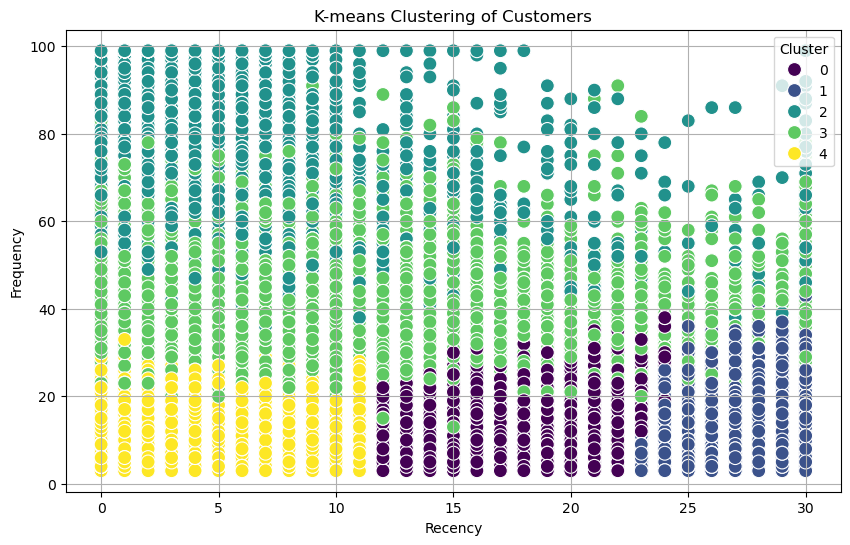

In [6]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

X = RFR[['recency', 'frequency', 'reordered']]

# 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-means 클러스터링 수행
kmeans = KMeans(n_clusters=5, random_state=42)  # 클러스터 개수는 필요에 따라 조정
RFR['cluster'] = kmeans.fit_predict(X_scaled)

# 결과 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(data=RFR, x='recency', y='frequency', hue='cluster', palette='viridis', s=100)
plt.title('K-means Clustering of Customers')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.legend(title='Cluster')
plt.grid()
plt.show()

In [185]:
RFR[RFR['cluster'] == 3]

,user_id,recency,frequency,reordered,cluster
16,17,27.0,40,211,3
35,36,7.0,37,98,3
51,52,10.0,27,118,3
62,63,13.0,39,307,3
70,71,18.0,23,331,3
...,...,...,...,...,...
206186,206187,14.0,34,195,3
206192,206193,3.0,41,181,3
206199,206200,1.0,23,184,3
206200,206201,16.0,32,230,3
